# Решение уравнения переноса

[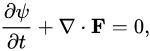](https://wikimedia.org/api/rest_v1/media/math/render/svg/119ef9d26ec5d13b85a4fec90e3ccab35752b5ef)

$$ \frac{\partial u(t, x)}{\partial t} + \alpha * \frac{\partial u(t, x)}{\partial x} = f(t, x) $$  
$$ 0 <= t <= T, 0 <= x <= X $$

#### Критерий устойчивости (необходимое условие сходимости):
$$ |\alpha| * \frac{\Delta t}{\Delta x} <= 1 $$

При всех последующих вычислениях он выполняется.

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

# Реализуем основные функции для удобного взаимодействия с данными и анализа.

In [35]:
# Функция f(t, x) = x + t
def f(t, x):
    return x + t

# Функция φ(x) = cos(pi * x)
def phi(x):
    return np.cos(np.pi * x)

# Функция ψ(t) = exp(-t)
def psi(t):
    return np.exp(-t)

# Параметры задачи
T = 1.0  # Время
X = 1.0  # Пространство
K = 100  # Количество шагов по времени
M = 100  # Количество шагов по пространству
tau = T / K  # Шаг по времени
h = X / M  # Шаг по пространству
a = 1.0  # Коэффициент переноса

In [36]:
def GetResultsFromCSV(filename):
    with open('../gen/' + filename + '.csv', 'r') as file:
        reader = csv.reader(file)
        next(reader, None)  # Пропустить заголовок
        t_from_file, x_from_file, u_from_file = np.array(list(reader)).transpose().astype(float)

    X_values, T_values = np.meshgrid(np.unique(x_from_file), np.unique(t_from_file))
    
    U_values = np.zeros_like(X_values)


    for i, xi in enumerate(np.unique(X_values)):
        for j, ti in enumerate(np.unique(T_values)):
            try:
                idx = np.where((x_from_file == xi) & (t_from_file == ti))[0][0]
                U_values[j, i] = u_from_file[idx] 
            except ValueError:
                print("Warning! Value error. xi =", xi, "ti =", ti)
                U_values[j, i] = 0
    
    return X_values, T_values, U_values

In [48]:
def f_u_teor(x, t):
    if 2 * t <= x:
        return x * t - t**2 / 2 + np.cos(np.pi * (2 * t - x))
    return x * t - t**2 / 2 + (2 * t - x) ** 2 / 8 + np.exp(-(t - x / 2))


def GetUTeor(x_values, t_values):
    u_teor_local = np.zeros_like(x_values)

    for i, xi in enumerate(np.unique(x_values)):
        for j, ti in enumerate(np.unique(t_values)):
            u_teor_local[i, j] = f_u_teor(xi, ti)
    
    return u_teor_local


def Graph3d(x, t, u):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, t, u, cmap='inferno')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')
    ax.view_init(20, 20)
    plt.show()


def GraphTwo3d(x, t, u1, u2, name_1, name_2):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), subplot_kw={'projection': '3d'})
    
    axes[0].plot_surface(x, t, u1, cmap='inferno')
    axes[0].set_title(name_1)
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('t')
    # axes[0].set_zlim(-2, 2)
    axes[0].view_init(20, 20)
    
    axes[1].plot_surface(x, t, u2, cmap='inferno')
    axes[1].set_title(name_2)
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('t')
    # axes[1].set_zlim(-2, 2)
    axes[1].view_init(20, 20)

    plt.show()


def GraphError(U_local, U_teor, x_values, t_values):
    U_error = np.zeros_like(x_values)
    U_relative = np.zeros_like(x_values)

    for i, xi in enumerate(np.unique(x_values)):
        for j, ti in enumerate(np.unique(t_values)):
            U_error[i, j] = np.abs(U_teor[i, j] - U_local[i, j])
            U_relative[i, j] = min(U_error[i, j] / np.abs(U_teor[i, j]) * 100, 200)
            
            if U_error[i, j] > 100:
                print(U_local[i, j], U_teor[i, j], U_error[i, j], U_relative[i, j])

    
    GraphTwo3d(x_values, t_values, U_error, U_relative, "Абсолютная погрешность", "Относительная погрешность")
    

def PrintToCsv(filename, T, X, U):
    # Вывод результата в файл .csv чтобы потом визуалилировать
    df = pd.DataFrame({'t': T.flatten(),
                    'x': X.flatten(),
                    'u': U.flatten()})
    df.to_csv('../gen/' + filename + '.csv', index=False)

# Посмотрим на аналитическое решение и решение параллельного алгоритма

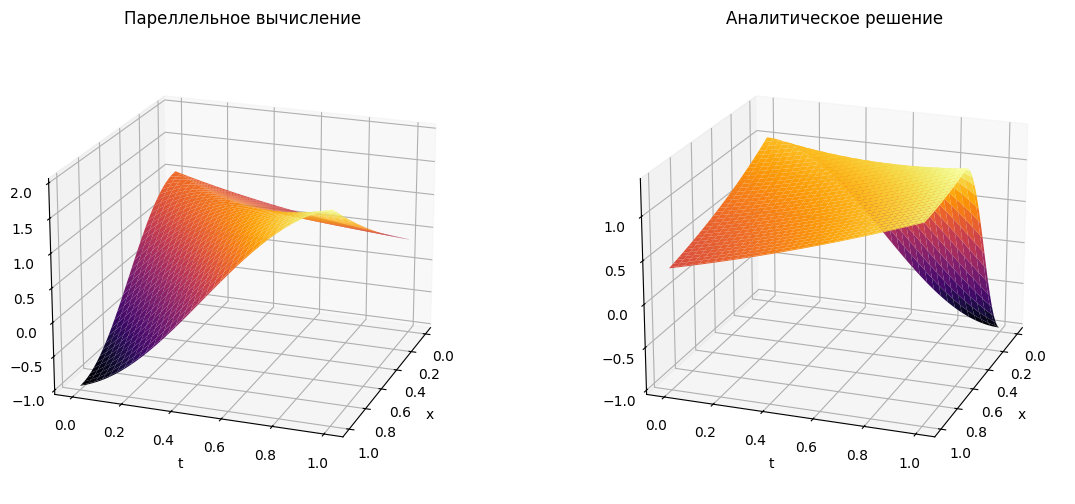

In [49]:
X_parallel, T_parallel, U_parallel = GetResultsFromCSV("solution_new")
U_t = GetUTeor(X_parallel, T_parallel)

GraphTwo3d(X_parallel, T_parallel, U_parallel, U_t, "Пареллельное вычисление", "Аналитическое решение")

Нууууу, если сильно не вглядываться, то вполне себе)))

# Посмотрим расхождение

Изобразим на графике ошибку решения с помощью параллельного алгоритма, реализованного на c++ - [файл](./1_lab.cpp).

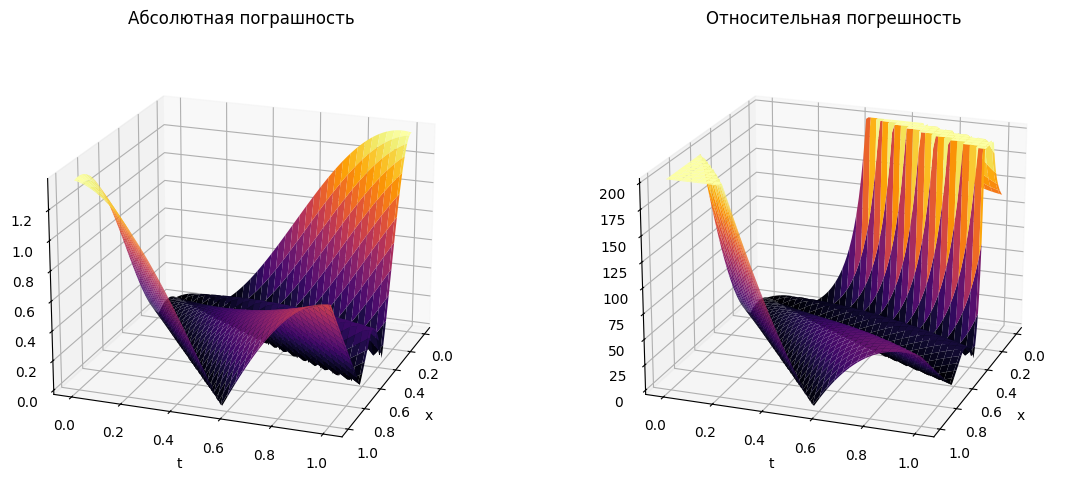

In [51]:

X_parallel, T_parallel, U_parallel = GetResultsFromCSV("solution_new")
U_t = GetUTeor(X_parallel, T_parallel)
GraphError(U_parallel, U_t, X_parallel, T_parallel)

# Проверим правильность параллельных вычислений

### Реализуем на питоне метод креста

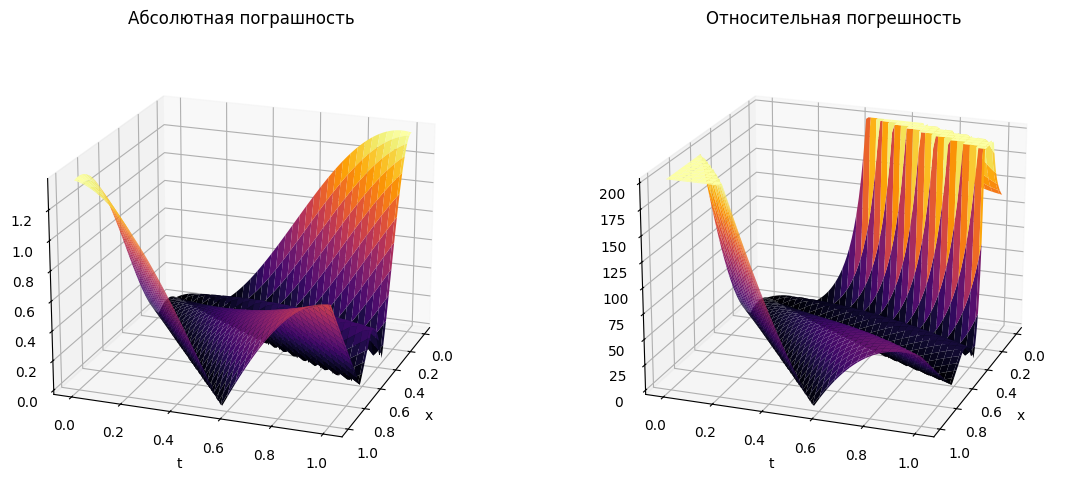

In [40]:
# Функция f(t, x) = x + t
def f(t, x):
    return x + t

# Функция φ(x) = cos(pi * x)
def phi(x):
    return np.cos(np.pi * x)

# Функция ψ(t) = exp(-t)
def psi(t):
    return np.exp(-t)

# Параметры задачи
T = 1.0  # Время
X = 1.0  # Пространство
K = 100  # Количество шагов по времени
M = 100  # Количество шагов по пространству
tau = T / K  # Шаг по времени
h = X / M  # Шаг по пространству
a = 1.0  # Коэффициент переноса


# Выделение памяти для решения
u = np.zeros((K + 1, M + 1))

# Начальное условие
for m in range(M + 1):
    u[0, m] = phi(m * h)

# Граничное условие
for k in range(0, K + 1):
    u[k, 0] = psi(k * tau)

# Первый временной слой (k = 0) - схема левый уголок
for m in range(1, M + 1):
    u[1, m] = u[0, m] - a * tau / h * (u[0, m] - u[0, m - 1]) + tau * f(0, m * h)

# Остальные временные слои (k = 1, 2, ..., K-1) - схема крест
for k in range(1, K):
    for m in range(1, M):
        # u[k + 1, m] = u[k - 1, m] - a * tau / h * (u[k, m + 1] - u[k, m - 1]) + 2 * tau * f(k * tau, m * h)
        u[k + 1, m] = u[k, m] - a * tau / h * (u[k, m] - u[k, m - 1]) + tau * f(k * tau, m * h)

    # Последний узел по пространству рассчитывается с помощью схемы "левый уголок"
    u[k + 1, M] = u[k, M] - a * tau / h * (u[k, M] - u[k, M - 1]) + tau * f(k * tau, M * h)


t = np.repeat(np.arange(0, T + tau, tau), M + 1).reshape(K + 1, M + 1)
x = np.tile(np.arange(0, X + h, h), K + 1).reshape(K + 1, M + 1)


U_t = GetUTeor(x, t)
GraphError(u, U_t, x, t)

Как видим, картина та же, значит параллелизм не загубил вычисления, что уже очень радует!

# Реализуем другие методы

### Явный левый уголок

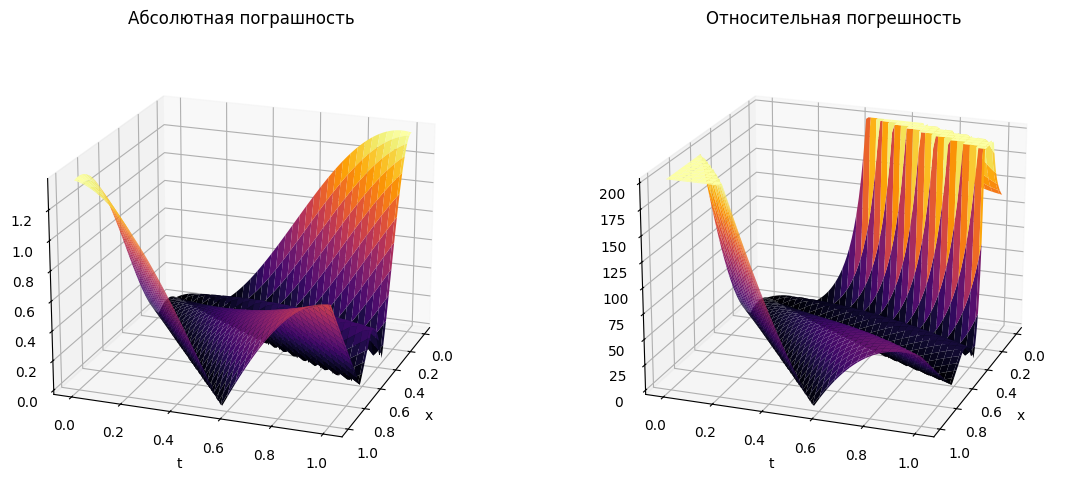

In [41]:
import numpy as np

# Функция f(t, x) = x + t
def f(t, x):
    return x + t

# Функция φ(x) = cos(pi * x)
def phi(x):
    return np.cos(np.pi * x)

# Функция ψ(t) = exp(-t)
def psi(t):
    return np.exp(-t)

# Параметры задачи
T = 1.0  # Время
X = 1.0  # Пространство
K = 100  # Количество шагов по времени
M = 100  # Количество шагов по пространству
tau = T / K  # Шаг по времени
h = X / M  # Шаг по пространству
a = 1.0  # Коэффициент переноса

# Выделение памяти для решения
u = np.zeros((K + 1, M + 1))

# Начальное условие
for m in range(M + 1):
    u[0, m] = phi(m * h)

# Реализация метода "левый уголок"
for k in range(K):
    # Граничное условие слева
    u[k + 1, 0] = psi((k + 1) * tau)

    # Вычисление решения для внутренних узлов
    for m in range(1, M + 1):
        u[k + 1, m] = u[k, m] - a * tau / h * (u[k, m] - u[k, m - 1]) + tau * f(k * tau, m * h)
        
U_t = GetUTeor(x, t)
GraphError(u, U_t, x, t)

### Неявный уголок

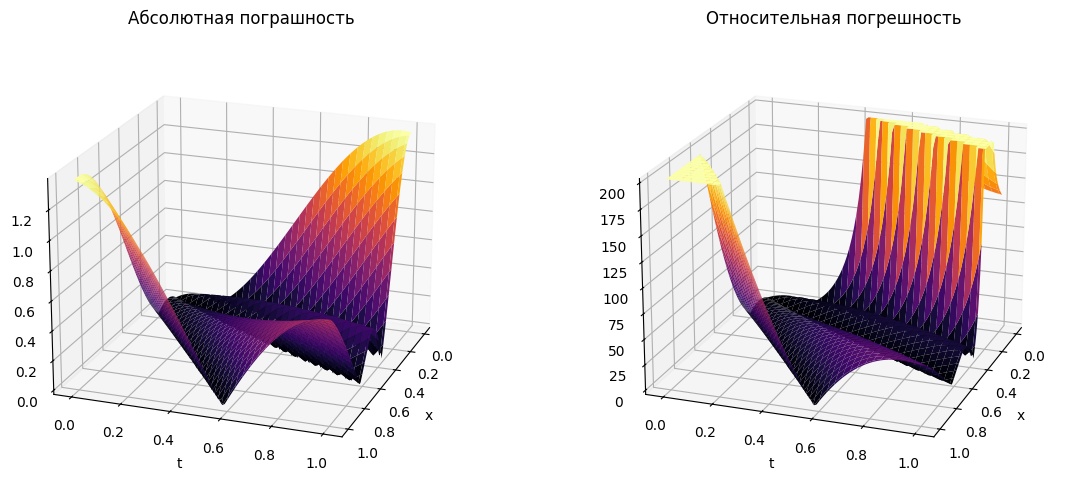

In [55]:
import numpy as np

# Функция f(t, x) = x + t
def f(t, x):
    return x + t

# Функция φ(x) = cos(pi * x)
def phi(x):
    return np.cos(np.pi * x)

# Функция ψ(t) = exp(-t)
def psi(t):
    return np.exp(-t)

# Параметры задачи
T = 1.0  # Время
X = 1.0  # Пространство
K = 100  # Количество шагов по времени
M = 100  # Количество шагов по пространству
tau = T / K  # Шаг по времени
h = X / M  # Шаг по пространству
a = 1.0  # Коэффициент переноса

# Выделение памяти для решения
u = np.zeros((K + 1, M + 1))

# Начальное условие
for m in range(M + 1):
    u[0, m] = phi(m * h)


# Создание матрицы системы для неявной схемы
A = np.zeros((M + 1, M + 1))
b = np.zeros(M + 1)

for k in range(K):
    # Граничное условие слева
    u[k + 1, 0] = psi((k + 1) * tau)
    A[0, 0] = 1
    b[0] = u[k + 1, 0]

    # Заполнение матрицы A и вектора b
    for m in range(1, M + 1):
        A[m, m - 1] = -a * tau / h  # Знак минус для неявного уголка
        A[m, m] = 1 + a * tau / h
        b[m] = u[k, m] + tau * f((k + 1) * tau, m * h)

    # Решение системы линейных уравнений
    u[k + 1, :] = np.linalg.solve(A, b)
    
U_t = GetUTeor(x, t)
GraphError(u, U_t, x, t)

### Метод прямоугольника

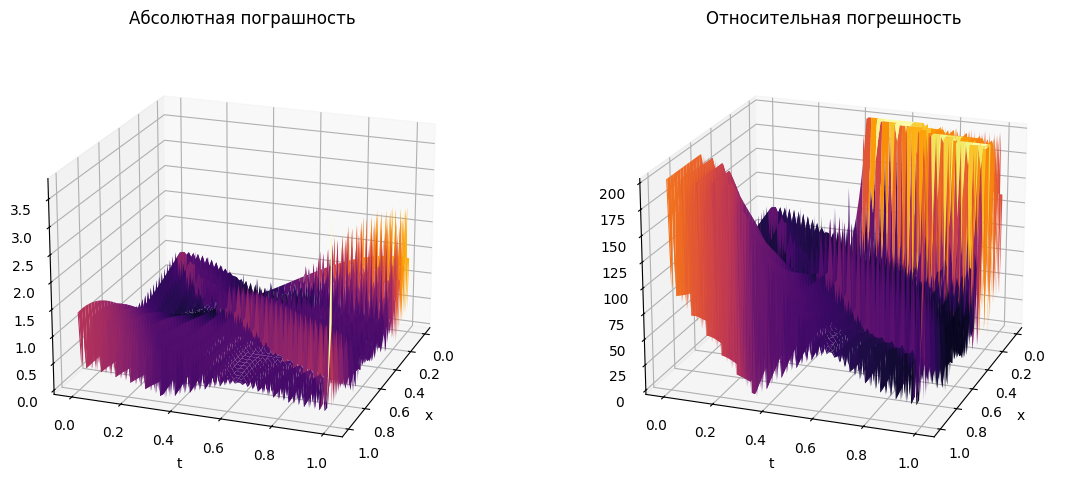

In [62]:
# Выделение памяти для решения
u = np.zeros((K + 1, M + 1))

# Начальное условие
for m in range(M + 1):
    u[0, m] = phi(m * h)

# Реализация метода "прямоугольника"
for k in range(K):
    # Граничное условие слева
    u[k + 1, 0] = psi((k + 1) * tau)

    # Вычисление решения для внутренних узлов
    for m in range(1, M):
        u[k + 1, m] = u[k - 1, m] - a * tau / h * (u[k, m + 1] - u[k, m - 1]) + 2 * tau * f((k + 0.5) * tau, m * h)
        
    # Граничное значение по-приколу сделаем экстраполяцией
    u[k + 1, M] = 2 * u[k + 1, M - 1] - u[k + 1, M - 2]
    # u[k + 1, M] = u[k, M] - a * tau / h * (u[k, M] - u[k, M - 1]) + tau * f(k * tau, M * h)

U_t = GetUTeor(x, t)
GraphError(u, U_t, x, t)

Попробовал для крайнего правого значения по пространству метод экстраполяции. График визуально не изменяется при замене на схему явного левого уголка.  
Да и в целом этот график - что-то новенькое в этом отчете. Я считаю красиво)